### Problem statement


- To understand which factor(s) play a larger part in affecting the price of resale HDBs in Singapore. 
- This project mainly investigates how a HDB unit's distance to shopping mall, hawker centre and/or MRT will impact the value of a HDB unit


- This will allow both buyers and sellers alike to understand the estimated market value of a HDB unit in question with respect to the proximity of a unit to the aforementioned factors


- This project will utilize the Singapore HDB datasets transaction from (2012 - 2021), along with the regression model to determine the upcoming HDB resale prices. 


- The predicted resale prices will be summbitted to [Kaggle](https://www.kaggle.com/competitions/dsi-sg-project-2-regression-challenge-hdb-price/overview) for scoring.


### Importing Library


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns

from sklearn.model_selection import train_test_split , cross_val_score , cross_val_predict 
from sklearn.linear_model import LinearRegression, LassoCV , RidgeCV , ElasticNet 
from sklearn.preprocessing import StandardScaler 


from sklearn.dummy import DummyRegressor

from statsmodels.api import qqplot


from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
import math

from PIL import Image



### 1. Data Loading

In [2]:
hdb_pd= pd.read_csv('./datasets/train.csv')

/var/folders/9h/g66bx9554bn3vx164q9t1k3m0000gp/T/ipykernel_19300/3500901359.py:1: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  hdb_pd= pd.read_csv('./datasets/train.csv')


In [3]:
hdb_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150634 entries, 0 to 150633
Data columns (total 77 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         150634 non-null  int64  
 1   Tranc_YearMonth            150634 non-null  object 
 2   town                       150634 non-null  object 
 3   flat_type                  150634 non-null  object 
 4   block                      150634 non-null  object 
 5   street_name                150634 non-null  object 
 6   storey_range               150634 non-null  object 
 7   floor_area_sqm             150634 non-null  float64
 8   flat_model                 150634 non-null  object 
 9   lease_commence_date        150634 non-null  int64  
 10  resale_price               150634 non-null  float64
 11  Tranc_Year                 150634 non-null  int64  
 12  Tranc_Month                150634 non-null  int64  
 13  mid_storey                 15

In [4]:
hdb_pd.head()

,id,Tranc_YearMonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,88471,2016-05,KALLANG/WHAMPOA,4 ROOM,3B,UPP BOON KENG RD,10 TO 12,90.0,Model A,2006,...,78,1,1.317659,103.882504,1138.633422,Geylang Methodist School,224,0,1.317659,103.882504
1,122598,2012-07,BISHAN,5 ROOM,153,BISHAN ST 13,07 TO 09,130.0,Improved,1987,...,45,1,1.349783,103.854529,447.894399,Kuo Chuan Presbyterian Secondary School,232,0,1.350110,103.854892
2,170897,2013-07,BUKIT BATOK,EXECUTIVE,289B,BT BATOK ST 25,13 TO 15,144.0,Apartment,1997,...,39,0,1.345245,103.756265,180.074558,Yusof Ishak Secondary School,188,0,1.342334,103.760013
3,86070,2012-04,BISHAN,4 ROOM,232,BISHAN ST 22,01 TO 05,103.0,Model A,1992,...,20,1,1.354789,103.844934,389.515528,Catholic High School,253,1,1.354789,103.844934
4,153632,2017-12,YISHUN,4 ROOM,876,YISHUN ST 81,01 TO 03,83.0,Simplified,1987,...,74,0,1.416280,103.838798,312.025435,Orchid Park Secondary School,208,0,1.414888,103.838335


Numeric variables

- `floor-area_sqm`:describle the floor area of the house, no missing data 
- `lease_commence_date`: no missing data, it show when the flat is build and how old is the flat
- `resale price`: thi is a price value for the house. which is an result of all the var combine together
- `town`: represent which area the flat is in singapore
- `tranc_year`: this represent the year the flat is sold
- `tranc_month`: from Jan to Dec), no missing data
- `mid_storey`, `lower`, `upper`, `mid`: this represent the storey range the house is show, it is similar to`storey_range` variable
- `floor_area_sqft`: describle the floor area of the house, no missing data, but it is same as`floor-area_sqm`
- `hdb_age`: no missing data, it represent how old is the flat since build
- `max_floor_lvl`: no missing values, it represent the max floor for this house sold
- `year_completed`: no missing values, it is similar to `hdb_age`. we can drop 1 of this variable
- `total_dwelling_units`: present total amount of unit in that blk
- `1/2/3/4/5room/exec/multigen/studio_apartment_sold/rental`: no missing values, it represent this blk consist of what type of unit
- `latitude/longitude`: no missing values,represent the blk location in GPS
- `mall_nearest_distance`: 829 missing values, can be caculate base on long/lat if this variable is used.
- `mall_within_500m/1km/2km`: count of number of malls within radius, useful aggregation and predictor variable. but there are missing data it in. might need to do data processing 
- `hawker` variables: similar to `mall` variables, no missing data
- `mrt/bus` variables: similar to `mall` variables with the added benefit that there are no missing values
- `pri_sch/sec_sch` variables: no missing values, but distance, vacancy and afflication have different effects, may need to use all carefully. Range of variables look reasonable. Cutoff point for `sec_sch` is a good proxy for 'desirability' of the school

### 2. Data Cleaning and Exploratory Data Analysis

In [5]:
#change Tranc_YearMonth to date
hdb_pd['Tranc_YearMonth'] = pd.DatetimeIndex(hdb_pd['Tranc_YearMonth'])

In [6]:
#total missing data for Mall_Nearest_distance
hdb_pd['Mall_Nearest_Distance'].isnull().sum()

829

In [7]:
#mean of Mall_Nearest_Distance
hdb_pd['Mall_Nearest_Distance'].mean()

664.2398262895447

In [8]:
#fill missing data of Mall_Nearest_distance with mean Mall_Nearest_Distance
hdb_pd['Mall_Nearest_Distance'] = hdb_pd['Mall_Nearest_Distance'].fillna(hdb_pd['Mall_Nearest_Distance'].mean())

/var/folders/9h/g66bx9554bn3vx164q9t1k3m0000gp/T/ipykernel_19300/3806090338.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_xticklabels(xlable)


Text(0.5, 0, 'Reasle Price')

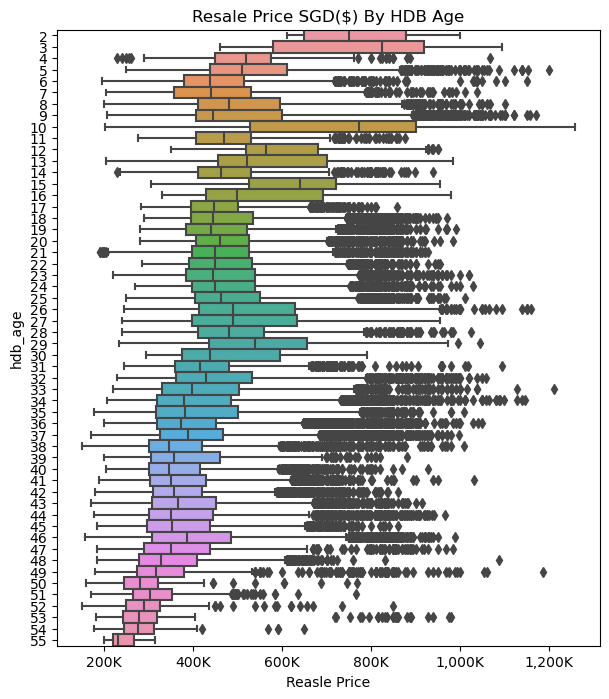

In [9]:
fig =plt.figure(figsize=(7,8))
p=sns.boxplot(y ='hdb_age', x='resale_price', data=hdb_pd, width=1 , orient='h')

xlable = ['{:,.0f}'.format(x)+ 'K' for x in p.get_xticks()/1000]
p.set_xticklabels(xlable)
p.set_title('Resale Price SGD($) By HDB Age')
p.set_xlabel('Reasle Price')

Above finding shows a linear relationship between the age of a HDB flat and the resale price. That is, the younger the HDB flat, the higher the resale price. This could be a result of the below HDB regulation. Image reference and source link is as per below. 
[Link](https://www.hdb.gov.sg/residential/buying-a-flat/financing-a-flat-purchase/housing-loan-options/housing-loan-from-hdb)

<function matplotlib.pyplot.show(close=None, block=None)>

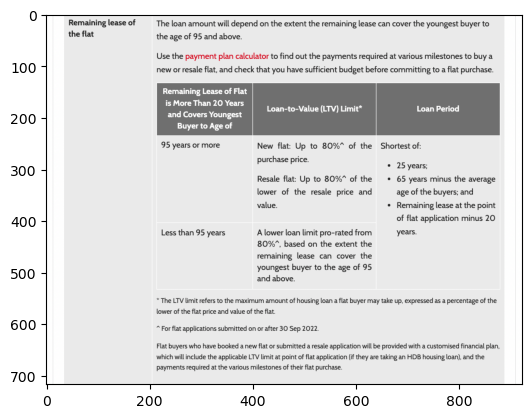

In [10]:
regulation = img.imread('./plot/HDB regulation.png')
plt.imshow(regulation)
plt.show

/var/folders/9h/g66bx9554bn3vx164q9t1k3m0000gp/T/ipykernel_19300/763237091.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_xticklabels(xlable)


Text(0.5, 0, 'Reasle Price')

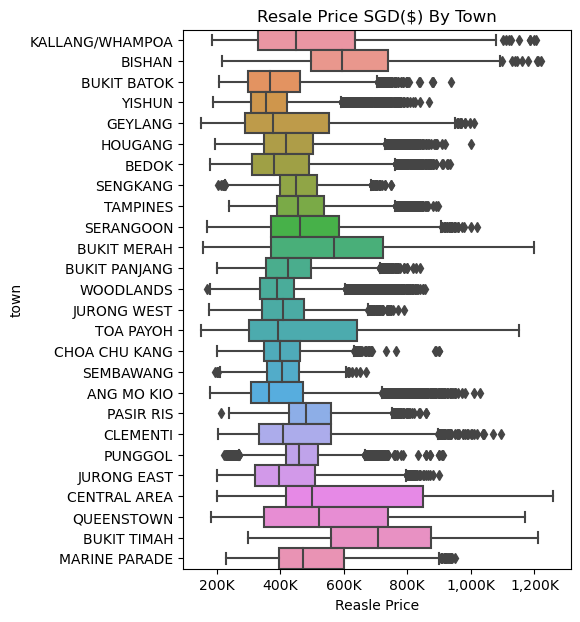

In [11]:
fig =plt.figure(figsize=(5,7))
p=sns.boxplot(y ='town', x='resale_price', data=hdb_pd, width=1 , orient='h')

xlable = ['{:,.0f}'.format(x)+ 'K' for x in p.get_xticks()/1000]
p.set_xticklabels(xlable)
p.set_title('Resale Price SGD($) By Town')
p.set_xlabel('Reasle Price')

From this box plot, we can infer the Central areas like Queentown and Bukit Timah have a higher resale price compared to the other neighbourhoods. 
This could be because of Central neighbourhood's close proximity to highly connected MRT interchanges like 'Outram Park' and 'Dhoby Ghaut'. 

<function matplotlib.pyplot.show(close=None, block=None)>

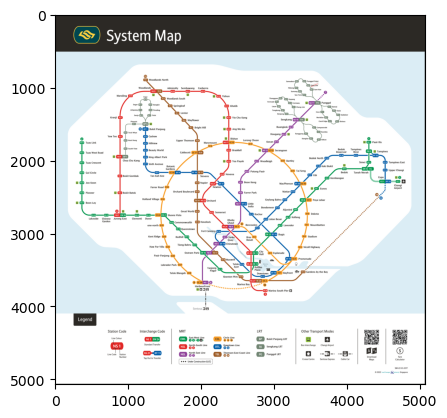

In [12]:
MRT_map = img.imread('./plot/MRT map.png')
plt.imshow(MRT_map)
plt.show

/var/folders/9h/g66bx9554bn3vx164q9t1k3m0000gp/T/ipykernel_19300/2338643148.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_xticklabels(xlable)


Text(0.5, 0, 'Reasle Price')

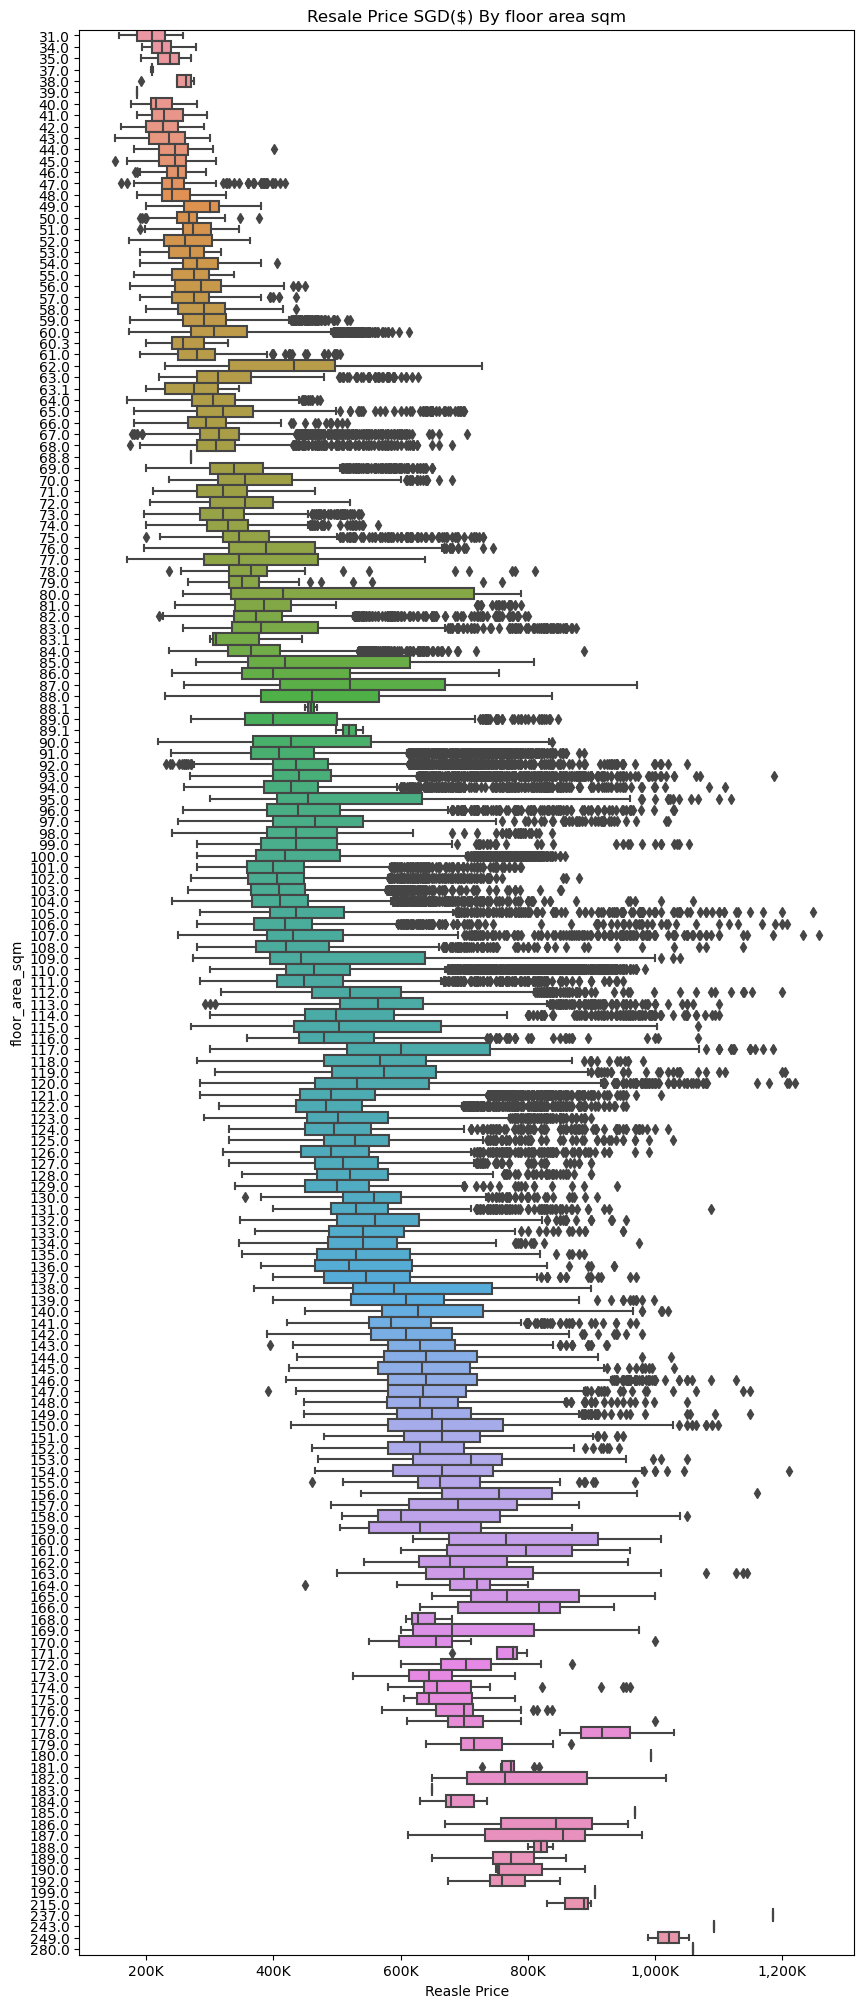

In [13]:
fig =plt.figure(figsize=(10,25))
p=sns.boxplot(y ='floor_area_sqm', x='resale_price', data=hdb_pd, width=1 , orient='h')

xlable = ['{:,.0f}'.format(x)+ 'K' for x in p.get_xticks()/1000]
p.set_xticklabels(xlable)
p.set_title('Resale Price SGD($) By floor area sqm')
p.set_xlabel('Reasle Price')

The larger HDB unit's floor area (sqm), the higher the resale price. 

/var/folders/9h/g66bx9554bn3vx164q9t1k3m0000gp/T/ipykernel_19300/3109507010.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_xticklabels(xlable)


Text(0.5, 0, 'Reasle Price')

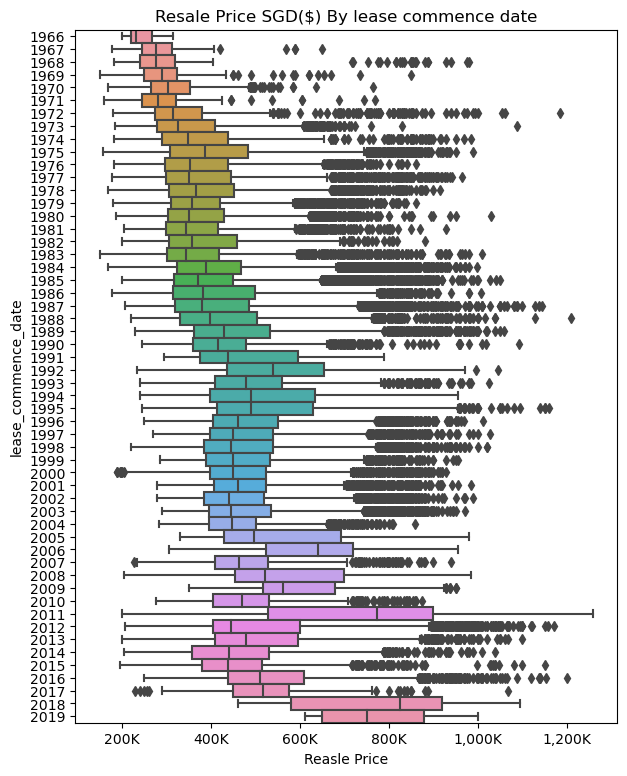

In [14]:
fig =plt.figure(figsize=(7,9))
p=sns.boxplot(y ='lease_commence_date', x='resale_price', data=hdb_pd, width=1 , orient='h')

xlable = ['{:,.0f}'.format(x)+ 'K' for x in p.get_xticks()/1000]
p.set_xticklabels(xlable)
p.set_title('Resale Price SGD($) By lease commence date')
p.set_xlabel('Reasle Price')

Given Lease Commence Date is inversely proportionate to that of HDB age, we will be dropping this feature from the model prediction to prevent multicollinearity. 

/var/folders/9h/g66bx9554bn3vx164q9t1k3m0000gp/T/ipykernel_19300/2749634350.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_xticklabels(xlable)


Text(0.5, 0, 'Reasle Price')

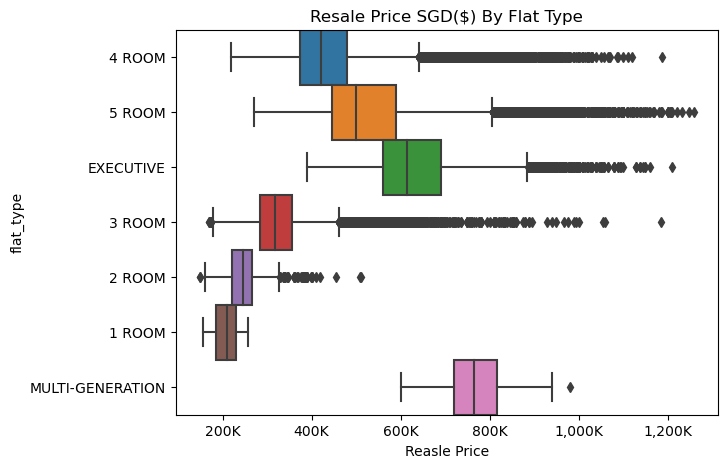

In [15]:
fig =plt.figure(figsize=(7,5))
p=sns.boxplot(y ='flat_type', x='resale_price', data=hdb_pd, width=1 , orient='h')

xlable = ['{:,.0f}'.format(x)+ 'K' for x in p.get_xticks()/1000]
p.set_xticklabels(xlable)
p.set_title('Resale Price SGD($) By Flat Type')
p.set_xlabel('Reasle Price')

/var/folders/9h/g66bx9554bn3vx164q9t1k3m0000gp/T/ipykernel_19300/4255012901.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_xticklabels(xlable)


Text(0.5, 0, 'Reasle Price')

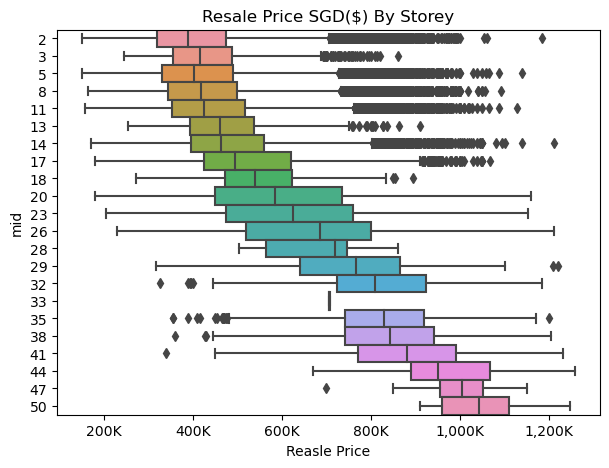

In [16]:
fig =plt.figure(figsize=(7,5))
p=sns.boxplot(y ='mid', x='resale_price', data=hdb_pd, width=1 , orient='h')

xlable = ['{:,.0f}'.format(x)+ 'K' for x in p.get_xticks()/1000]
p.set_xticklabels(xlable)
p.set_title('Resale Price SGD($) By Storey')
p.set_xlabel('Reasle Price')

From the above box plot, we can see there is a linear relationship between the storey of the unit and the resale price. That is, the greater the elevation of a HDB unit, the higher the resale price. This is likely due to a preference for higher floors by prospective HDB owners as the higher elevation provides better sunlight and wind ventilation. In addition, higher storey units are less likely to be prone to pests infestation given the greater distance from the ground floor rubbish chute. 
[Link](https://www.propertyguru.com.sg/property-guides/high-floor-vs-low-floor-unit-which-is-better-45449)

Check for Correlation for features

In [17]:
hdb_corra_ascending=hdb_pd.corr()[['resale_price']].sort_values(by='resale_price',ascending=True)

/var/folders/9h/g66bx9554bn3vx164q9t1k3m0000gp/T/ipykernel_19300/1956151452.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  hdb_corra_ascending=hdb_pd.corr()[['resale_price']].sort_values(by='resale_price',ascending=True)


In [18]:
hdb_corra_ascending

,resale_price
3room_sold,-0.410368
hdb_age,-0.350337
sec_sch_latitude,-0.216303
Latitude,-0.216153
bus_stop_latitude,-0.215760
mrt_latitude,-0.214939
pri_sch_latitude,-0.214707
2room_sold,-0.145287
total_dwelling_units,-0.140725
mrt_nearest_distance,-0.128222


In [19]:
hdb_corra_decending=hdb_pd.corr()[['resale_price']].sort_values(by='resale_price',ascending=False)

/var/folders/9h/g66bx9554bn3vx164q9t1k3m0000gp/T/ipykernel_19300/2264001683.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  hdb_corra_decending=hdb_pd.corr()[['resale_price']].sort_values(by='resale_price',ascending=False)


In [20]:
hdb_corra_decending

,resale_price
resale_price,1.000000
floor_area_sqm,0.654120
floor_area_sqft,0.654120
id,0.521504
max_floor_lvl,0.495650
5room_sold,0.359434
year_completed,0.353698
upper,0.353552
mid_storey,0.353213
mid,0.353213


Drop id as it is a form of number index for the transcation

remove floor_area_sqm as it is same as floor_area_sqft (multicollinearity)

remove hdb age and year completed as it is same as lease commence date (multicollinearity)

remove room_sold as it is a noise and have no effect on prediction model

remove storey_range, lower , upper and mid. we will be using mid storey instead

we will remove school primary school and secondary school: name, lat and long and cutoff point, will instead use distance to primary and sec school to replace them

In [21]:
hdb_pd.drop(columns=['id','floor_area_sqm','cutoff_point','multistorey_carpark','precinct_pavilion','block','street_name','lower','upper','mid','lower','upper','mid','address','residential','commercial','market_hawker','total_dwelling_units','1room_sold','2room_sold','3room_sold','5room_sold','4room_sold','exec_sold','multigen_sold','studio_apartment_sold','1room_rental','2room_rental','3room_rental','other_room_rental','postal','Latitude','Longitude','planning_area','Mall_Within_500m','Mall_Within_1km','Mall_Within_2km','Hawker_Within_500m','Hawker_Within_1km','Hawker_Within_2km','hawker_food_stalls','hawker_market_stalls','mrt_name','bus_interchange','mrt_interchange','mrt_latitude','mrt_longitude','bus_stop_name','bus_stop_latitude','bus_stop_longitude','pri_sch_name','vacancy','pri_sch_affiliation','pri_sch_latitude','pri_sch_longitude','sec_sch_name','affiliation','sec_sch_latitude','sec_sch_longitude','lease_commence_date','year_completed'], inplace=True)

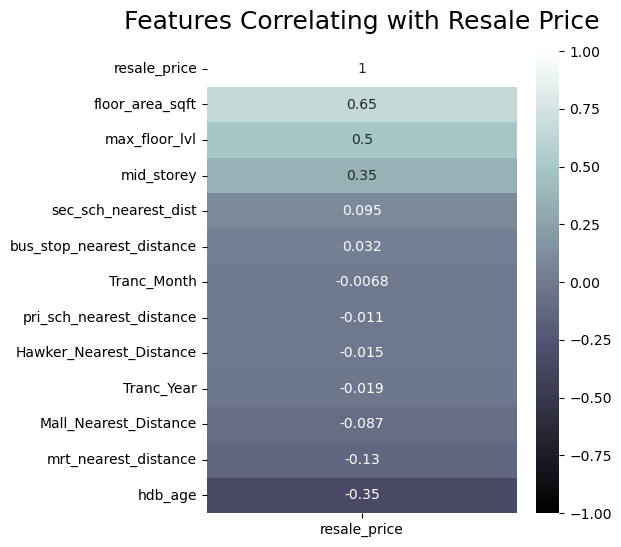

In [22]:
plt.figure(figsize=(5, 6))
heatmap = sns.heatmap(hdb_pd.corr(method='pearson',numeric_only=True)[['resale_price']].sort_values(by='resale_price', ascending=False), 
                      vmin=-1, vmax=1, annot=True, cmap='bone')
heatmap.set_title('Features Correlating with Resale Price', fontdict={'fontsize':18}, pad=16);

This chart show the feature correlation to resale price independently

In [23]:
hdb_pd.drop(columns=['Tranc_Month','Tranc_Year'], inplace=True)

variable to keep with correlation more than 0.1
and keep all the distance to amenities

In [24]:
hdb_pd.columns

Index(['Tranc_YearMonth', 'town', 'flat_type', 'storey_range', 'flat_model',
       'resale_price', 'mid_storey', 'full_flat_type', 'floor_area_sqft',
       'hdb_age', 'max_floor_lvl', 'Mall_Nearest_Distance',
       'Hawker_Nearest_Distance', 'mrt_nearest_distance',
       'bus_stop_nearest_distance', 'pri_sch_nearest_distance',
       'sec_sch_nearest_dist'],
      dtype='object')

In [25]:
for i in list(hdb_pd.select_dtypes(include='object').columns):
    print(i,len(set(hdb_pd[i].values)))

town 26
flat_type 7
storey_range 25
flat_model 20
full_flat_type 43


In [26]:
hdb_pd['town'].value_counts()

JURONG WEST        11451
WOODLANDS          11334
SENGKANG           11069
TAMPINES           10506
YISHUN             10042
BEDOK               9046
PUNGGOL             7793
HOUGANG             7555
ANG MO KIO          6908
CHOA CHU KANG       6343
BUKIT MERAH         5854
BUKIT PANJANG       5686
BUKIT BATOK         5623
TOA PAYOH           4817
PASIR RIS           4763
KALLANG/WHAMPOA     4340
QUEENSTOWN          4121
GEYLANG             3986
SEMBAWANG           3723
CLEMENTI            3633
JURONG EAST         3470
SERANGOON           3123
BISHAN              2871
CENTRAL AREA        1249
MARINE PARADE        959
BUKIT TIMAH          369
Name: town, dtype: int64

<AxesSubplot: >

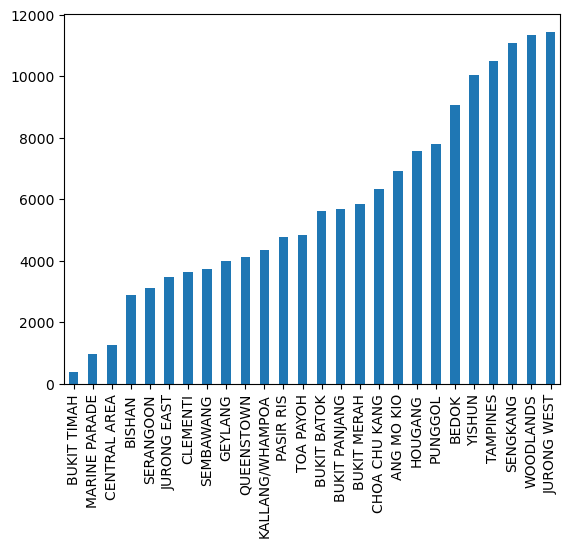

In [27]:
hdb_pd['town'].value_counts(ascending=True).plot(kind='bar')

In [28]:
hdb_pd['flat_type'].value_counts()

4 ROOM              61136
3 ROOM              39060
5 ROOM              36415
EXECUTIVE           11989
2 ROOM               1896
1 ROOM                 82
MULTI-GENERATION       56
Name: flat_type, dtype: int64

<AxesSubplot: >

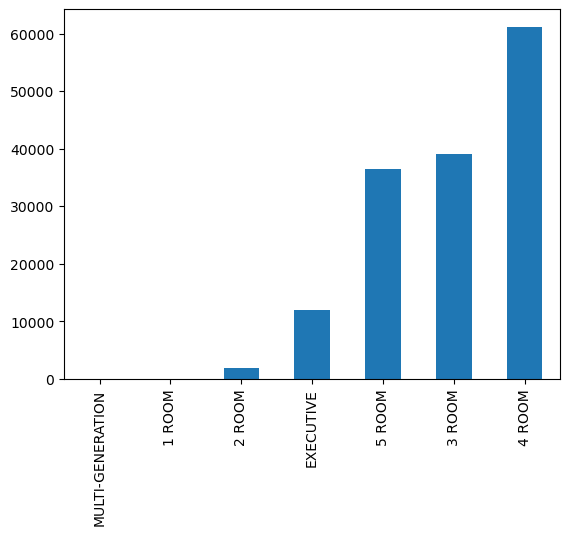

In [29]:
hdb_pd['flat_type'].value_counts(ascending=True).plot(kind='bar')

<AxesSubplot: >

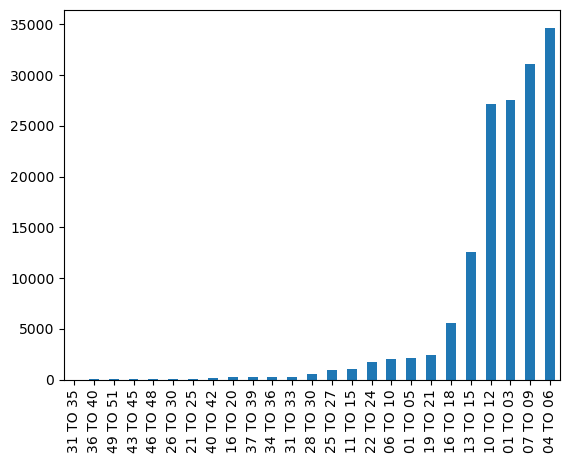

In [30]:
hdb_pd['storey_range'].value_counts(ascending=True).plot(kind='bar')

<AxesSubplot: >

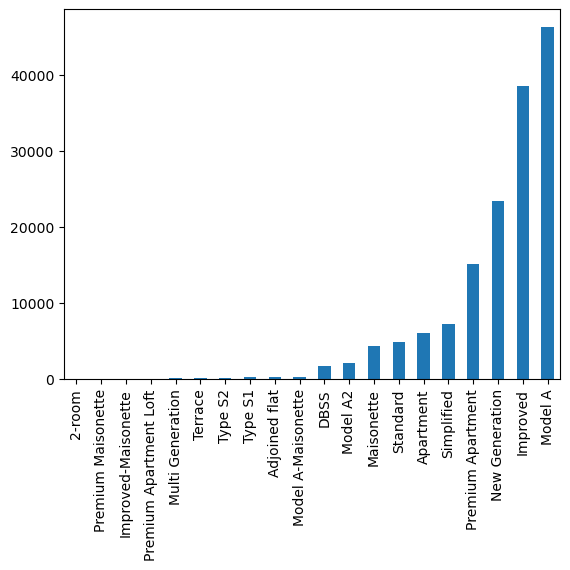

In [31]:
hdb_pd['flat_model'].value_counts(ascending=True).plot(kind='bar')

In [32]:
hdb_pd['full_flat_type'].value_counts()

4 ROOM Model A                       35127
5 ROOM Improved                      25824
3 ROOM New Generation                15227
3 ROOM Improved                      10240
3 ROOM Model A                        8454
4 ROOM New Generation                 8139
4 ROOM Premium Apartment              7667
EXECUTIVE Apartment                   6080
5 ROOM Premium Apartment              5535
4 ROOM Simplified                     5309
EXECUTIVE Maisonette                  4364
3 ROOM Standard                       2522
4 ROOM Model A2                       2064
5 ROOM Model A                        1941
3 ROOM Simplified                     1930
4 ROOM Improved                       1847
5 ROOM Standard                       1686
EXECUTIVE Premium Apartment           1435
5 ROOM DBSS                            869
2 ROOM Model A                         739
4 ROOM DBSS                            604
2 ROOM Standard                        594
2 ROOM Improved                        521
3 ROOM Prem

<AxesSubplot: >

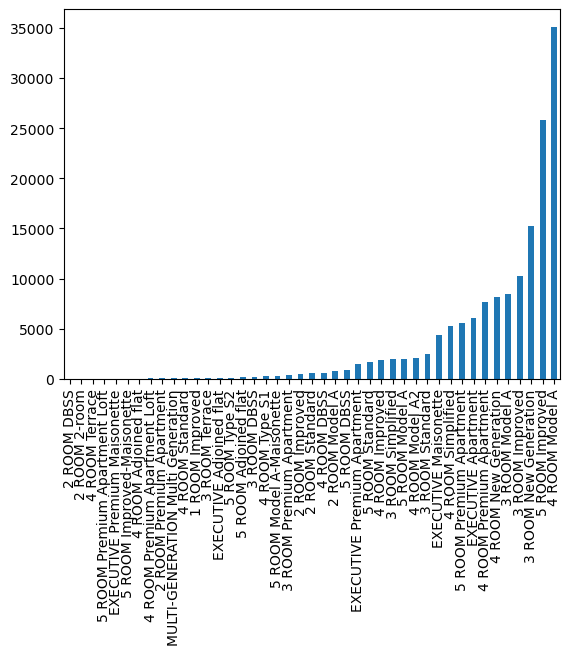

In [33]:
hdb_pd['full_flat_type'].value_counts(ascending=True).plot(kind='bar')

In [34]:
hdb_pd.isnull().sum()

Tranc_YearMonth              0
town                         0
flat_type                    0
storey_range                 0
flat_model                   0
resale_price                 0
mid_storey                   0
full_flat_type               0
floor_area_sqft              0
hdb_age                      0
max_floor_lvl                0
Mall_Nearest_Distance        0
Hawker_Nearest_Distance      0
mrt_nearest_distance         0
bus_stop_nearest_distance    0
pri_sch_nearest_distance     0
sec_sch_nearest_dist         0
dtype: int64

array([[<AxesSubplot: title={'center': 'Tranc_YearMonth'}>,
        <AxesSubplot: title={'center': 'resale_price'}>,
        <AxesSubplot: title={'center': 'mid_storey'}>],
       [<AxesSubplot: title={'center': 'floor_area_sqft'}>,
        <AxesSubplot: title={'center': 'hdb_age'}>,
        <AxesSubplot: title={'center': 'max_floor_lvl'}>],
       [<AxesSubplot: title={'center': 'Mall_Nearest_Distance'}>,
        <AxesSubplot: title={'center': 'Hawker_Nearest_Distance'}>,
        <AxesSubplot: title={'center': 'mrt_nearest_distance'}>],
       [<AxesSubplot: title={'center': 'bus_stop_nearest_distance'}>,
        <AxesSubplot: title={'center': 'pri_sch_nearest_distance'}>,
        <AxesSubplot: title={'center': 'sec_sch_nearest_dist'}>]],
      dtype=object)

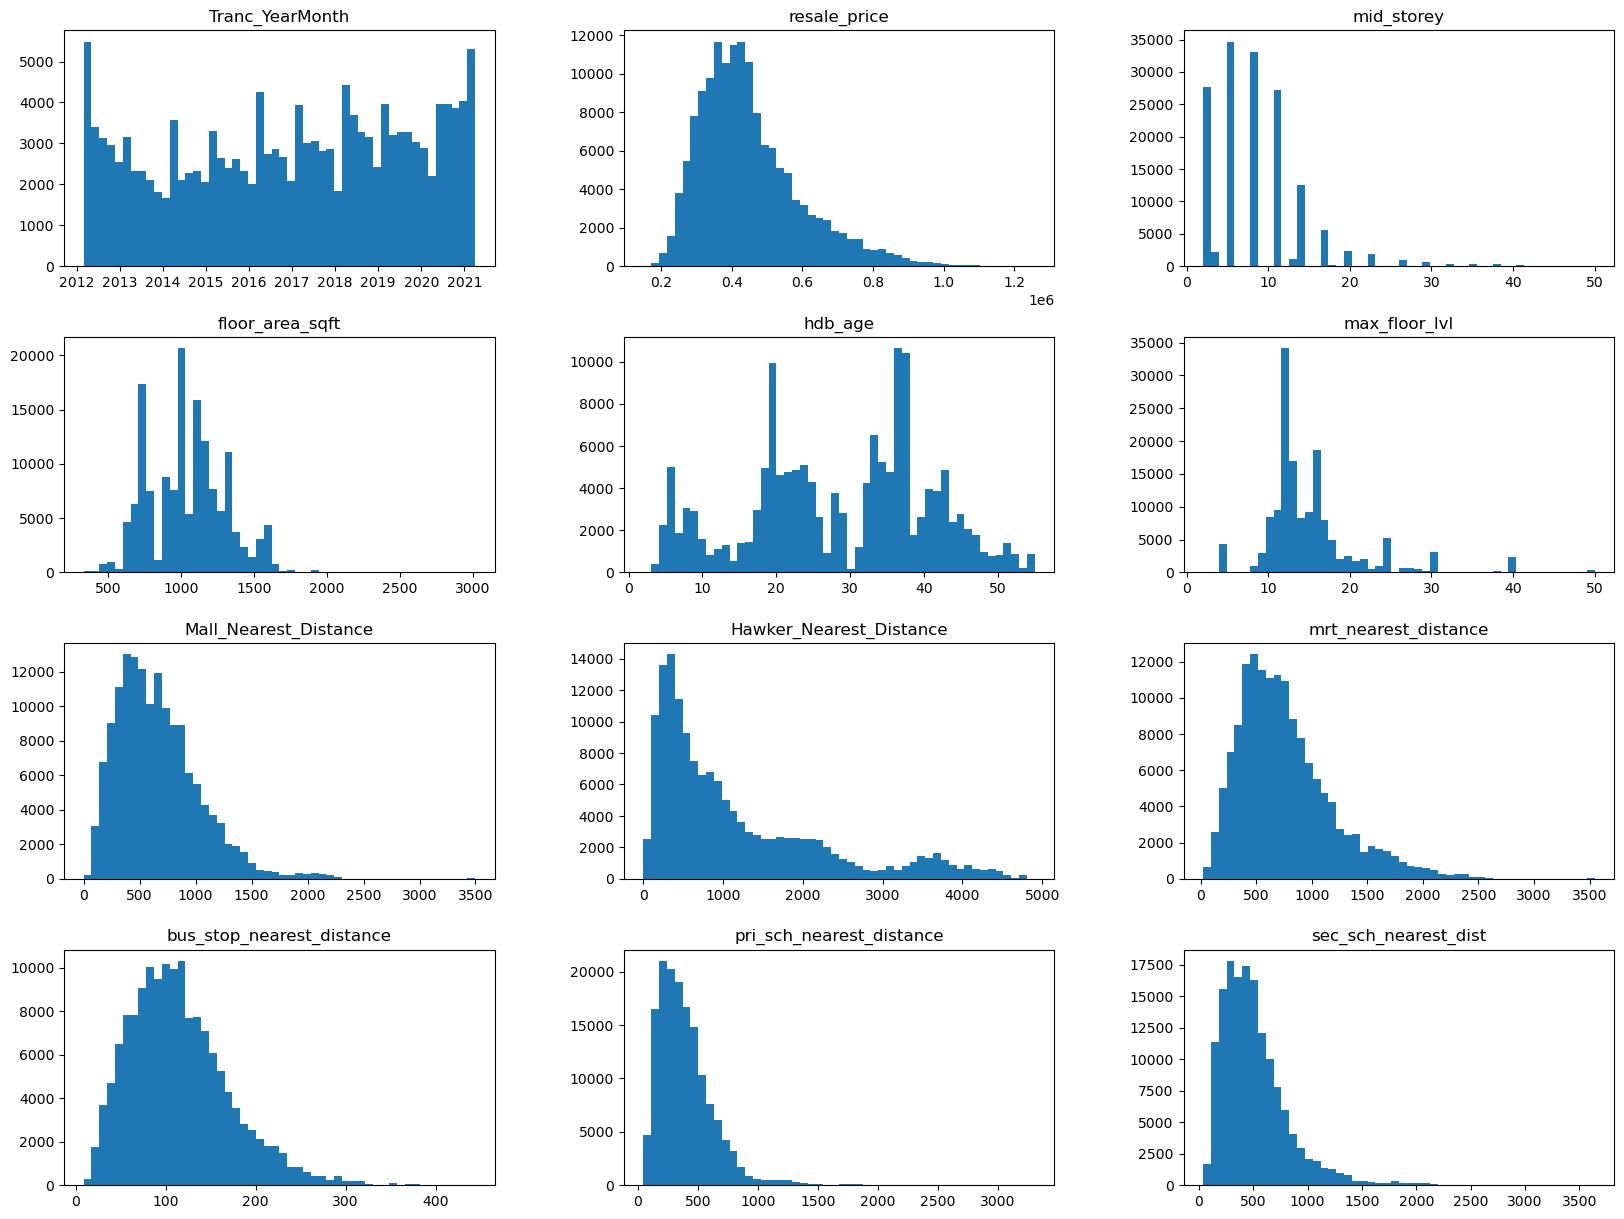

In [35]:
hdb_pd.hist(bins=50, figsize=(20,15), grid=False)

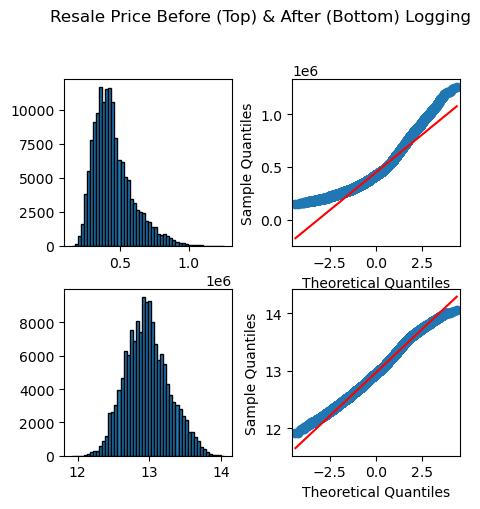

In [36]:
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2,figsize=(5,5))

ax1.hist(hdb_pd['resale_price'], bins=50, edgecolor='black')
qqplot(hdb_pd['resale_price'], line='s', ax=ax2)
ax3.hist(np.log(hdb_pd['resale_price']), bins=50, edgecolor='black')
qqplot(np.log(hdb_pd['resale_price']), line='s', ax=ax4)
plt.suptitle('Resale Price Before (Top) & After (Bottom) Logging')
plt.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.show()

Will be using log resale price for prediction model as i make the resale price normal distribution cruve but we will use orginal resale price to interpret the Coefficient of each feature.

/var/folders/9h/g66bx9554bn3vx164q9t1k3m0000gp/T/ipykernel_19300/723198625.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(ylabels)


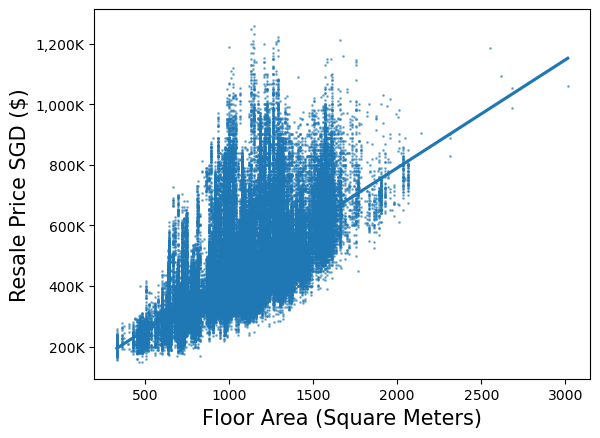

In [37]:
p=sns.regplot(x='floor_area_sqft', y='resale_price', data=hdb_pd, scatter_kws={"s": 1, 'alpha':0.5})
ylabels = ['{:,.0f}'.format(x) + 'K' for x in p.get_yticks()/1000]
p.set_yticklabels(ylabels)
p.set_ylabel('Resale Price SGD ($)', size=15)
p.set_xlabel('Floor Area (Square Meters)', size=15)
plt.show()

### 3. Data Preparation

In [38]:
#scaling of data
#scaler = StandardScaler()

# fit to continuous columns and transform
#scaled_columns = ['floor_area_sqft','lease_commence_date','Hawker_Nearest_Distance',
#                  'Mall_Nearest_Distance','mrt_nearest_distance','bus_stop_nearest_distance',
#                  'pri_sch_nearest_distance','sec_sch_nearest_dist' ]
                 
#scaler.fit(hdb_pd[scaled_columns])
#scaled_columns = pd.DataFrame(scaler.transform(hdb_pd[scaled_columns]), index=hdb_pd.index, columns=scaled_columns)

# separate unscaled features
#unscaled_columns = hdb_pd.drop(scaled_columns, axis=1)

# concatenate scaled and unscaled features
#hdb_pd = pd.concat([scaled_columns,unscaled_columns], axis=1)
#hdb_pd

standardscaling for feature does not effect the prediction result after trying, therefore i decided to remove it so we can iinterpret the Coefficient of each feature

We will be using flat_type and town to create dummies 

In [39]:
create_dummy = pd.get_dummies(hdb_pd[['town','flat_type']],drop_first=True)

In [40]:
create_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150634 entries, 0 to 150633
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype
---  ------                      --------------   -----
 0   town_BEDOK                  150634 non-null  uint8
 1   town_BISHAN                 150634 non-null  uint8
 2   town_BUKIT BATOK            150634 non-null  uint8
 3   town_BUKIT MERAH            150634 non-null  uint8
 4   town_BUKIT PANJANG          150634 non-null  uint8
 5   town_BUKIT TIMAH            150634 non-null  uint8
 6   town_CENTRAL AREA           150634 non-null  uint8
 7   town_CHOA CHU KANG          150634 non-null  uint8
 8   town_CLEMENTI               150634 non-null  uint8
 9   town_GEYLANG                150634 non-null  uint8
 10  town_HOUGANG                150634 non-null  uint8
 11  town_JURONG EAST            150634 non-null  uint8
 12  town_JURONG WEST            150634 non-null  uint8
 13  town_KALLANG/WHAMPOA        150634 non-null 

In [41]:
hdb_pd.drop(columns=['town','flat_type','storey_range','flat_model','full_flat_type','Tranc_YearMonth'], inplace=True)

Merge dummy and processed data


In [42]:
hdb_final=pd.merge(hdb_pd,create_dummy, how='left', left_index=True, right_index=True)

In [43]:
hdb_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150634 entries, 0 to 150633
Data columns (total 42 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   resale_price                150634 non-null  float64
 1   mid_storey                  150634 non-null  int64  
 2   floor_area_sqft             150634 non-null  float64
 3   hdb_age                     150634 non-null  int64  
 4   max_floor_lvl               150634 non-null  int64  
 5   Mall_Nearest_Distance       150634 non-null  float64
 6   Hawker_Nearest_Distance     150634 non-null  float64
 7   mrt_nearest_distance        150634 non-null  float64
 8   bus_stop_nearest_distance   150634 non-null  float64
 9   pri_sch_nearest_distance    150634 non-null  float64
 10  sec_sch_nearest_dist        150634 non-null  float64
 11  town_BEDOK                  150634 non-null  uint8  
 12  town_BISHAN                 150634 non-null  uint8  
 13  town_BUKIT BAT

In [44]:
hdb_final.to_csv('./datasets/hdb_final_data.csv')

### 4. Train Test Split

from above chart we can see the resale price is log compare to highest corelation area. therefor we will log the reslae price for model training

In [45]:
# set X and y for train test split
y = np.log(hdb_final['resale_price'])
X = hdb_final.drop(columns=['resale_price'])
y_no_log = hdb_final['resale_price']

In [46]:
lr=LinearRegression()
X_train,X_test,y_train,y_test =train_test_split(X,y_no_log,random_state=30, stratify=hdb_final[['mid_storey']])

### 5. BASE LINE MODEL Linear Model

In [47]:
def test_metric(model, X_train, X_test, y_train, y_test, metric='r2_score', cv=5, modifier='linear'):
    """
    Function to return specified test metric for train, validation and test sets
    
    Parameters
    ----------
       
    model: sklearn model
        model to run predictions on
    
    X_train: pandas Dataframe
        training predictor dataset
    
    X_test: pandas Dataframe
        test predictor dataset
        
    y_train: pandas Series/Dataframe
        training outcome dataset
        
    y_test: pandas Series/Dataframe
        test outcome dataset

    metric: str
        'r2_score' - evaluates R2 score (default)
        'rmse' - evaluates root mean squared error
        'rmape' - evaluates root mean absolute percentage error
        
    cv: int
        number of cross validation folds (default = 5)
        
    modifier: str
        'linear' - y is resale price with no modification
        'log' - y is np.log(resale price))
        
    Returns
    -------
    Prints out metric in 3 lines
    
    """
    
    # import libraries
    from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
    import numpy as np
    
    if modifier == 'linear':
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
    elif modifier == 'log':
        y_pred_train = np.exp(model.predict(X_train))
        y_pred_test = np.exp(model.predict(X_test))
        y_train = np.exp(y_train)
        y_test = np.exp(y_test)
    
    # select function to use
    if metric == 'r2_score':
        train_metric = r2_score(y_train, y_pred_train)
        cross_metric = cross_val_score(model, X_train, y_train, cv=cv).mean()
        test_metric = r2_score(y_test, y_pred_test)
    elif metric == 'rmse':
        train_metric = mean_squared_error(y_train, y_pred_train, squared=False)
        cross_metric = -1 * cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
        test_metric = mean_squared_error(y_test, y_pred_test, squared=False)
    elif metric == 'rmape':
        train_metric = mean_absolute_percentage_error(y_train, y_pred_train)
        cross_metric = -1 * cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_absolute_percentage_error').mean()
        test_metric = mean_absolute_percentage_error(y_test, y_pred_test)
    else:
        print('ERROR: Invalid metric chosen')
        return
        
    print(f'Train {metric.upper()}:           \t{train_metric:.4f}')
    print(f'{cv}-Fold CV {metric.upper()}:     \t{cross_metric:.4f}')
    print(f'Test {metric.upper()}:            \t{test_metric:.4f}')

Base model will be base on median

In [48]:
#fit base model
base_model = DummyRegressor(strategy='median')
base_model.fit(X_train, y_train)

DummyRegressor(strategy='median')

In [49]:
#base model RMSE
test_metric(base_model, X_train, X_test, y_train, y_test, metric='rmse', modifier='linear')

Train RMSE:           	145983.2300
5-Fold CV RMSE:     	145844.7283
Test RMSE:            	147023.6545


### 6. Linear Regression

In [50]:
#fit linear model
lr=lr.fit(X_train,y_train)

In [51]:
#linear model score on train set
lr.score(X_train,y_train)

0.8525085336851882

In [52]:
lr.intercept_

219665.48848810839

In [53]:
#linear model RSME
test_metric(lr, X_train, X_test, y_train, y_test, metric='rmse', modifier='linear')

Train RMSE:           	54941.1158
5-Fold CV RMSE:     	54959.6103
Test RMSE:            	55052.0814


In [54]:
(lr.coef_)

array([ 3.43644223e+03,  3.30182398e+02, -3.71081471e+03,  3.28639923e+03,
       -1.29335089e+01, -2.10980150e+01, -5.95578420e+01, -1.25533945e+00,
        1.20843244e+01,  1.16708572e+01, -2.23147689e+04,  9.25922301e+04,
       -4.96150483e+04,  6.47681912e+04, -1.18520380e+05,  1.50572187e+05,
        5.98000892e+04, -1.10157055e+05,  2.58216194e+04,  6.87043060e+03,
       -5.33192384e+04, -5.89374615e+04, -1.04863494e+05,  2.06150549e+04,
        1.90620593e+05, -7.18559689e+04, -3.38840681e+04,  5.53787125e+04,
       -1.52953318e+05, -7.89717617e+04,  3.12438718e+04, -3.28046829e+04,
        1.81712782e+04, -1.49969770e+05, -8.17092179e+04, -1.54292055e+04,
        1.20612144e+04,  2.25798297e+04,  3.41505260e+04,  7.71108931e+04,
        1.48900778e+05])

In [55]:
#linear model on test set
lr.score(X_test,y_test)

0.85394273196713

In [56]:
cross_val_score(lr, X_train,y_train,cv=5).mean()

0.8523995271385016

In [57]:
#predited price in log on train set
y_pred = lr.predict(X_train)
y_pred

array([563419.5040847 , 364669.14142369, 540273.25971241, ...,
       428041.46901452, 432104.8132813 , 407280.69648145])

In [58]:
print(mean_absolute_percentage_error(y_train,y_pred))

0.09944347067443615


In [59]:
r2_score(y_train,y_pred)

0.8525085336851882

In [60]:
#actully price vs predicted price in train set
price = {'resale_price': (list(y_train)),'predicted_resale_price': (list(y_pred))}
result= pd.DataFrame(price)


In [61]:
result['difference_from_orginal_in_%']= (result['predicted_resale_price']-result['resale_price'])/result['resale_price']*100

In [62]:
result_20_difference = result[(result['difference_from_orginal_in_%']>10) | (result['difference_from_orginal_in_%']<-10)]
result_20_difference


,resale_price,predicted_resale_price,difference_from_orginal_in_%
2,650888.0,540273.259712,-16.994435
3,670000.0,584651.876923,-12.738526
5,550000.0,612440.207153,11.352765
6,365000.0,426057.811832,16.728168
10,505000.0,562664.448048,11.418703
...,...,...,...
112968,822000.0,719654.086908,-12.450841
112969,500000.0,567741.766779,13.548353
112970,472000.0,567768.887515,20.290019
112971,477000.0,377830.937454,-20.790160


### 7. Comparing accuracy evaluation from Lasso, Ridge and ElasticNet models

In [63]:
#lasso model
lasso = LassoCV(n_alphas=200)

In [64]:
#ridge model
ridge = RidgeCV(alphas=np.linspace(.1,10,100))

In [65]:
#fit linear model
lr=lr.fit(X_train,y_train)
list_lr_coef=list(lr.coef_)

In [66]:
compare_lr_coef_variable = {'feature': list(X_train.columns[0:]),'coef':list_lr_coef}
compare_lr_coef_variable= pd.DataFrame(compare_lr_coef_variable)

In [67]:
lasso=lasso.fit(X_train,y_train)
list_lasso_coef=list(lasso.coef_)
lasso.coef_

array([ 2.86913049e+03,  3.54455352e+02, -1.29113741e+03,  7.18611399e+03,
        5.98146393e+00, -2.34420018e+01, -5.73520789e+01,  6.27700452e+01,
        1.14607289e+01,  3.43908172e+01, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00])

In [68]:
lasso.intercept_

20733.159887764195

most feature coef has been reduce to 0, we will compare later

In [69]:
compare_lasso_coef_variable = {'feature': list(X_train.columns[0:]),'coef':list_lasso_coef}
compare_lasso_coef_variable= pd.DataFrame(compare_lasso_coef_variable)

In [70]:
#lasso score
lasso_scores = cross_val_score(lasso, X_test, y_test, cv=5)
lasso_scores.mean()

0.7018945161226278

In [71]:
#lasso RSME
test_metric(lasso, X_train, X_test, y_train, y_test, metric='rmse', modifier='linear')

Train RMSE:           	77900.7637
5-Fold CV RMSE:     	77907.4608
Test RMSE:            	78574.7884


In [72]:
ridge=ridge.fit(X_train,y_train)
ridge.coef_
list_ridge_coef=list(ridge.coef_)

In [73]:
compare_ridge_coef_variable = {'feature': list(X_train.columns[0:]),'coef':list_ridge_coef}
compare_ridge_coef_variable= pd.DataFrame(compare_ridge_coef_variable)

In [74]:
#ridge score
ridge_scores = cross_val_score(ridge, X_test, y_test, cv=5)
ridge_scores.mean()

0.8536139872786975

In [75]:
ridge.intercept_

220165.01000543934

In [76]:
#ridge RSME
test_metric(ridge, X_train, X_test, y_train, y_test, metric='rmse', modifier='linear')

Train RMSE:           	54941.1495
5-Fold CV RMSE:     	54959.7626
Test RMSE:            	55052.0386


In [77]:
#fit Elasticnet model
elas =ElasticNet()

In [78]:
elas=elas.fit(X_train,y_train)
elas.coef_
list_elas_coef=list(elas.coef_)

In [79]:
compare_elas_coef_variable = {'feature': list(X_train.columns[0:]),'coef':list_elas_coef}
compare_elas_coef_variable= pd.DataFrame(compare_elas_coef_variable)

In [80]:
#Elasticnet score
elas_score = cross_val_score(elas, X_test, y_test, cv=5)
elas_score.mean()

0.7213246797318776

In [81]:
elas.intercept_

24618.460982999357

In [82]:
#Elasticnet RMSE
test_metric(elas, X_train, X_test, y_train, y_test, metric='rmse', modifier='linear')

Train RMSE:           	75353.6549
5-Fold CV RMSE:     	75361.0256
Test RMSE:            	76019.6085


In [83]:
#combine coef for linear, ridge, lasso, elasticnet model
compare_all_coef_variable = {'feature': list(X_train.columns[0:]),
                             'lr coef':list_lr_coef,
                             'ridge coef':list_ridge_coef,
                             'lasso coef':list_lasso_coef,
                             'elas coef':list_elas_coef}
compare_all_coef_variable= pd.DataFrame(compare_all_coef_variable)
compare_all_coef_variable

,feature,lr coef,ridge coef,lasso coef,elas coef
0,mid_storey,3436.442233,3436.469946,2869.130493,3465.079787
1,floor_area_sqft,330.182398,330.164539,354.455352,356.417629
2,hdb_age,-3710.814712,-3710.680203,-1291.137408,-1518.559982
3,max_floor_lvl,3286.399230,3286.825921,7186.113985,7213.677988
4,Mall_Nearest_Distance,-12.933509,-12.926556,5.981464,6.391457
5,Hawker_Nearest_Distance,-21.098015,-21.143959,-23.442002,-25.072708
6,mrt_nearest_distance,-59.557842,-59.584801,-57.352079,-58.333709
7,bus_stop_nearest_distance,-1.255339,-1.258932,62.770045,65.020901
8,pri_sch_nearest_distance,12.084324,12.090528,11.460729,11.744970
9,sec_sch_nearest_dist,11.670857,11.729229,34.390817,32.336815


In [84]:
# top 10 coef feature that effect the resale price
compare_all_coef_variable.sort_values(by='lr coef',ascending=False).head(10)

,feature,lr coef,ridge coef,lasso coef,elas coef
24,town_MARINE PARADE,190620.592676,190602.544038,0.0,2210.822447
15,town_BUKIT TIMAH,150572.187453,150519.780352,0.0,794.410892
40,flat_type_MULTI-GENERATION,148900.778205,148066.970922,0.0,89.482657
11,town_BISHAN,92592.230116,92599.529607,0.0,4708.470014
39,flat_type_EXECUTIVE,77110.893057,76614.116357,0.0,3185.677512
13,town_BUKIT MERAH,64768.191169,64766.799141,0.0,4992.198539
16,town_CENTRAL AREA,59800.089219,59796.788299,0.0,633.457666
27,town_QUEENSTOWN,55378.712470,55383.166649,0.0,2419.436791
38,flat_type_5 ROOM,34150.526032,33669.523861,-0.0,-2401.088748
30,town_SERANGOON,31243.871845,31258.441570,0.0,3299.951743


In [85]:
# top 10 -coef feature that effect the resale price
compare_all_coef_variable.sort_values(by='lr coef',ascending=False).tail(10)

,feature,lr coef,ridge coef,lasso coef,elas coef
20,town_HOUGANG,-53319.238394,-53304.729015,0.0,248.133775
21,town_JURONG EAST,-58937.461479,-58927.784384,-0.0,-1919.336890
25,town_PASIR RIS,-71855.968902,-71842.448505,-0.0,-774.244081
29,town_SENGKANG,-78971.761678,-78945.503225,-0.0,-391.594356
34,town_YISHUN,-81709.217929,-81692.798406,-0.0,-2990.420607
22,town_JURONG WEST,-104863.494405,-104846.536036,-0.0,-6411.506630
17,town_CHOA CHU KANG,-110157.054634,-110129.182707,-0.0,-2847.684856
14,town_BUKIT PANJANG,-118520.380495,-118503.262872,-0.0,-4465.362930
33,town_WOODLANDS,-149969.769563,-149955.359688,-0.0,-10781.957441
28,town_SEMBAWANG,-152953.317954,-152923.519049,-0.0,-3539.929034


### 8. Predicting test resale prices for kaggle

In [86]:
def pre_processing_date(df,pred):
    """
    Function to read file and proccess cleaning and save it for predition model
    
    Parameters
    ----------
       
    df: read file name
    
    pred: save file name
    
    Returns
    -------
    save file 
    
    """
#read file
    hdb_pd= pd.read_csv((f'./datasets/{df}.csv'))
#replace nan value
    hdb_pd['Mall_Nearest_Distance'] = hdb_pd['Mall_Nearest_Distance'].fillna(hdb_pd['Mall_Nearest_Distance'].mean())
#drop unwanted columns
    hdb_pd.drop(columns=['id','floor_area_sqm','cutoff_point','multistorey_carpark','precinct_pavilion','block','street_name','lower','upper','mid','lower','upper','mid','address','residential','commercial','market_hawker','total_dwelling_units','1room_sold','2room_sold','3room_sold','5room_sold','4room_sold','exec_sold','multigen_sold','studio_apartment_sold','1room_rental','2room_rental','3room_rental','other_room_rental','postal','Latitude','Longitude','planning_area','Mall_Within_500m','Mall_Within_1km','Mall_Within_2km','Hawker_Within_500m','Hawker_Within_1km','Hawker_Within_2km','hawker_food_stalls','hawker_market_stalls','mrt_name','bus_interchange','mrt_interchange','mrt_latitude','mrt_longitude','bus_stop_name','bus_stop_latitude','bus_stop_longitude','pri_sch_name','vacancy','pri_sch_affiliation','pri_sch_latitude','pri_sch_longitude','sec_sch_name','affiliation','sec_sch_latitude','sec_sch_longitude','lease_commence_date','year_completed'], inplace=True)
    hdb_pd.drop(columns=['Tranc_Month','Tranc_Year'], inplace=True)

#scale feature    
#    scaler = StandardScaler()

# fit to continuous columns and transform
#    scaled_columns = ['floor_area_sqft','hdb_age','Hawker_Nearest_Distance',
#                  'Mall_Nearest_Distance','mrt_nearest_distance','bus_stop_nearest_distance',
#                  'pri_sch_nearest_distance','sec_sch_nearest_dist' ]
                 
#    scaler.fit(hdb_pd[scaled_columns])
#    scaled_columns = pd.DataFrame(scaler.transform(hdb_pd[scaled_columns]), index=hdb_pd.index, columns=scaled_columns)

# separate unscaled features
#    unscaled_columns = hdb_pd.drop(scaled_columns, axis=1)

# concatenate scaled and unscaled features
#    hdb_pd= pd.concat([scaled_columns,unscaled_columns], axis=1)
    
    
# create dummy    
    create_dummy = pd.get_dummies(hdb_pd[['town','flat_type']],drop_first=True)
    
    hdb_pd.drop(columns=['town','flat_type','storey_range','flat_model','full_flat_type','Tranc_YearMonth'], inplace=True)

    
    
#merge file    
    hdb_final_pred=pd.merge(hdb_pd,create_dummy, how='left', left_index=True, right_index=True)
    hdb_final_pred.to_csv((f'./datasets/{pred}.csv'), index=False)
    


In [87]:
pre_processing_date('test', 'pred')

/var/folders/9h/g66bx9554bn3vx164q9t1k3m0000gp/T/ipykernel_19300/3892452412.py:18: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  hdb_pd= pd.read_csv((f'./datasets/{df}.csv'))


In [88]:
hdb_pred_pd= pd.read_csv('./datasets/pred.csv')

In [89]:
hdb_pred_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   mid_storey                  16737 non-null  int64  
 1   floor_area_sqft             16737 non-null  float64
 2   price_per_sqft              16737 non-null  float64
 3   hdb_age                     16737 non-null  int64  
 4   max_floor_lvl               16737 non-null  int64  
 5   Mall_Nearest_Distance       16737 non-null  float64
 6   Hawker_Nearest_Distance     16737 non-null  float64
 7   mrt_nearest_distance        16737 non-null  float64
 8   bus_stop_nearest_distance   16737 non-null  float64
 9   pri_sch_nearest_distance    16737 non-null  float64
 10  sec_sch_nearest_dist        16737 non-null  float64
 11  town_BEDOK                  16737 non-null  int64  
 12  town_BISHAN                 16737 non-null  int64  
 13  town_BUKIT BATOK            167

In [90]:
# this columns should be remove
hdb_pred_pd.drop(columns=['price_per_sqft'],inplace=True)

In [91]:
# using linear regression model with log price, as from EDA we should normal distribution the resale price 
lr_log = LinearRegression()
y = np.log(hdb_final['resale_price'])
X = hdb_final.drop(columns=['resale_price'])

X_train,X_test,y_train_log ,y_test_log =train_test_split(X,y,random_state=30 )
lr_log=lr_log.fit(X_train,y_train_log)

In [92]:
test_metric(lr_log, X_train, X_test, y_train_log, y_test_log, metric='r2_score', cv=5, modifier='log')

Train R2_SCORE:           	0.8812
5-Fold CV R2_SCORE:     	0.8527
Test R2_SCORE:            	0.8805


In [93]:
test_metric(lr_log, X_train, X_test, y_train_log, y_test_log, metric='rmse', cv=5, modifier='log')

Train RMSE:           	49412.9620
5-Fold CV RMSE:     	55018.4940
Test RMSE:            	49468.5079


In [94]:
test_metric(lr_log, X_train, X_test, y_train_log, y_test_log, metric='rmape', cv=5, modifier='log')

Train RMAPE:           	0.0862
5-Fold CV RMAPE:     	0.0994
Test RMAPE:            	0.0861


In [95]:
actually_pred_lr = lr_log.predict(hdb_pred_pd)
actually_pred_lr = np.exp(actually_pred_lr)
actually_pred_lr

array([342471.70936159, 506746.46043079, 330536.10373769, ...,
       401546.08735518, 472052.43008265, 348451.07592009])

In [96]:
def save_pred_summition(pred,name): 
    """
    Function to read file and proccess cleaning and save it for predition model
    
    Parameters
    ----------
       
    df: read file name
    
    pred: save file name
    
    Returns
    -------
    save file 
    
    """
    
    prices = {'Predicted': list(pred)}
    test= pd.read_csv('./datasets/sample_sub_reg.csv')
    results= pd.DataFrame(prices)
    results= pd.merge(test,results,how='left', left_index=True, right_index=True )
    results.drop(columns=['Predicted_x'],inplace=True)
    results.rename(columns={'Predicted_y':'Predicted'}, inplace=True)
    results.to_csv(f'./datasets/{name}.csv', index=False)


In [97]:
save_pred_summition(actually_pred_lr,'lr')

In [98]:
# summary for coef
coef_per_unit_change = {'feature': list(X_train.columns[0:]),
                             'lr coef':list_lr_coef}
coef_per_unit_change= pd.DataFrame(coef_per_unit_change)
coef_per_unit_change

,feature,lr coef
0,mid_storey,3436.442233
1,floor_area_sqft,330.182398
2,hdb_age,-3710.814712
3,max_floor_lvl,3286.399230
4,Mall_Nearest_Distance,-12.933509
5,Hawker_Nearest_Distance,-21.098015
6,mrt_nearest_distance,-59.557842
7,bus_stop_nearest_distance,-1.255339
8,pri_sch_nearest_distance,12.084324
9,sec_sch_nearest_dist,11.670857


<function matplotlib.pyplot.show(close=None, block=None)>

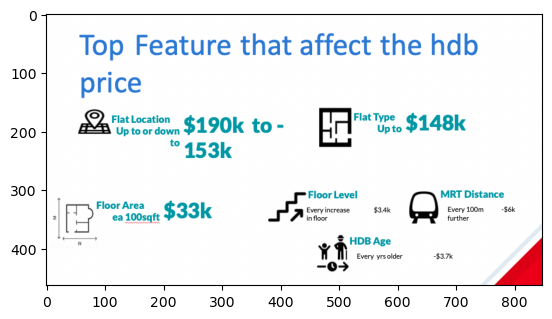

In [99]:
top_feature = img.imread('./plot/top feature.png')
plt.imshow(top_feature)
plt.show

### 9. Conclusion


Linear regression was used in this project to review the main contributing features to the HDB resale prices. 
This is because linear regression allows us to interpret the results of the model by looking at its coefficients for each feature. 
However, it assumes a linear relationship between the features and the outcome, which isn't always the case in real life.

Looking at the output of both the linear and lasso regression models, both models showed similar findings. Town location, floor area, flat model, hdb age and distance from MRT are the top 5 features influecing HDB prices. 

All in all, buyers who are price sensitive may want to focus on HDBs located in the North. For example, Woodlands and Sembawang as prices are generally lower in this region. 



### 10. Things I can improve on in the future

- We may want to separate the datasets by flat type. This would allow analyst to specifically focus on the targeted flat type instead of inputting the entire dataset into the model, which would provide a lower accuracy when analyzing a specific flat type. 

- We can also create models incorporating all the features while excluding features that are similar to each other. Subsequently, analyst may choose to remove each individual feature at a time to verify the model's accuracy and choose to improve it further. 

- In addition, the resale prices within the dataset might not have the same feature value as it is now. 
- This is because certain ammenities (e.g. Schools, Shopping malls, Hawker Center) and transportation features (e.g. bus stops with express busses, newer MRT routes) might not have been built or launched when the flat was sold. 
- To elaborate, HDBs within close proximity to the Downtown line today (launched in 2017) would have been relatively further from the main North-South line in the 1960s thus the resale prices would have been considerably cheaper then, causing the dataset to be inaccurate by today's standards. 

- Lastly, the dataset have yet to take into account the Housing Inflation Index to provide a more accurate prediction model. Analyst may choose to incorporate this datapoint into the model to improve the accuracy of the model. 